# Object Detection with Street View House Numbers

This notebook illustrates how to build a deep CNN using Keras’ functional API to generate multiple outputs: one to predict how many digits are present, and five for the value of each in the order they appear.

## Imports & Settings

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, 
                                     BatchNormalization, Activation, Concatenate)
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from matplotlib.ticker import FuncFormatter

In [2]:
sns.set_style('whitegrid')

In [3]:
DATA_PATH = Path('images', 'svhn')

### Settings

In [4]:
IMG_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
SEQ_LENGTH = 4
N_CLASSES = 11

## Load Data 

In [5]:
X_train = np.load(DATA_PATH / 'X_train.npy')
y_train = np.load(DATA_PATH / 'y_train.npy')

Removing the rare cases of 5-digit house numbers.

In [6]:
X_train = X_train[y_train[:, 0] < 5]
y_train = y_train[y_train[:, 0] < 5, :5]
y_train[:, 0] -= 1

In [7]:
X_test = np.load(DATA_PATH / 'X_test.npy')
y_test = np.load(DATA_PATH / 'y_test.npy')

In [8]:
X_test = X_test[y_test[:, 0] < 5]
y_test = y_test[y_test[:, 0] < 5, :5]
y_test[:, 0] -= 1

In [9]:
pd.DataFrame(y_train).nunique()

0     4
1    10
2    11
3    11
4    11
dtype: int64

In [10]:
y_train.shape

(33392, 5)

## Best Architecture

[Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks](https://arxiv.org/abs/1312.6082), Goodfellow, et al, 2014

In [11]:
digit_pos = {1: [4, 14], 2: [14, 25], 3: [25, 36], 4: [36, 47]}

In [12]:
def weighted_accuracy(y_true, y_pred):
    n_digits_pred = K.argmax(y_pred[:, :SEQ_LENGTH], axis=1)

    digit_preds = {}
    for digit, (start, end) in digit_pos.items():
        digit_preds[digit] = K.argmax(y_pred[:, start:end], axis=1)
    preds = tf.dtypes.cast(tf.stack((n_digits_pred,
                                     digit_preds[1],
                                     digit_preds[2],
                                     digit_preds[3],
                                     digit_preds[4]), axis=1), tf.float32)

    return K.mean(K.sum(tf.dtypes.cast(K.equal(y_true, preds), tf.int64), axis=1) / 5)

In [13]:
def weighted_entropy(y_true, y_pred):
    cce = tf.keras.losses.SparseCategoricalCrossentropy()
    n_digits = y_pred[:, :SEQ_LENGTH]

    digits = {}
    for digit, (start, end) in digit_pos.items():
        digits[digit] = y_pred[:, start:end]
    return (cce(y_true[:, 0], n_digits) +
            cce(y_true[:, 1], digits[1]) +
            cce(y_true[:, 2], digits[2]) +
            cce(y_true[:, 3], digits[3]) +
            cce(y_true[:, 4], digits[4])) / 5

In [14]:
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
vgg16.trainable = False
x = vgg16.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
n_digits = Dense(SEQ_LENGTH, activation='softmax', name='n_digits')(x)
digit1 = Dense(N_CLASSES-1, activation='softmax', name='d1')(x)
digit2 = Dense(N_CLASSES, activation='softmax', name='d2')(x)
digit3 = Dense(N_CLASSES, activation='softmax', name='d3')(x)
digit4 = Dense(N_CLASSES, activation='softmax', name='d4')(x)
predictions = Concatenate()([n_digits, digit1, digit2, digit3, digit4])

model = Model(inputs=vgg16.input, outputs=predictions)

In [15]:
model.compile(optimizer='adam',
              loss=weighted_entropy,
              metrics=[weighted_accuracy])

As a result, the model produces five distinct outputs that we can evaluate.

## Define Callbacks

In [16]:
svhn_path = 'models/svhn.cnn.weights.best.hdf5'
checkpointer = ModelCheckpoint(filepath=svhn_path, 
                               verbose=1, 
                               monitor='val_weighted_accuracy',
                               save_best_only=True)

In [17]:
early_stopping = EarlyStopping(monitor='val_weighted_accuracy', 
                               patience=5)

## Train Transfer Model

In [18]:
epochs = 50

In [19]:
history = model.fit(x=X_train,
                    y=y_train,
                    validation_split=.1,
                    batch_size=32,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[checkpointer, early_stopping])

Train on 30052 samples, validate on 3340 samples
Epoch 1/50
30048/30052 [============================>.] - ETA: 0s - loss: 1.0651 - weighted_accuracy: 0.6415
Epoch 00001: val_weighted_accuracy improved from -inf to 0.67581, saving model to models/svhn.cnn.weights.best.hdf5
30052/30052 [==============================] - 141s 5ms/sample - loss: 1.0652 - weighted_accuracy: 0.6415 - val_loss: 0.9635 - val_weighted_accuracy: 0.6758
Epoch 2/50
30048/30052 [============================>.] - ETA: 0s - loss: 0.9256 - weighted_accuracy: 0.6839
Epoch 00002: val_weighted_accuracy improved from 0.67581 to 0.68956, saving model to models/svhn.cnn.weights.best.hdf5
30052/30052 [==============================] - 137s 5ms/sample - loss: 0.9256 - weighted_accuracy: 0.6839 - val_loss: 0.9170 - val_weighted_accuracy: 0.6896
Epoch 3/50
30048/30052 [============================>.] - ETA: 0s - loss: 0.8801 - weighted_accuracy: 0.6991
Epoch 00003: val_weighted_accuracy improved from 0.68956 to 0.69429, saving

### Evaluate Results

In [20]:
metrics = pd.DataFrame(history.history)
initial_epochs = len(metrics)

In [21]:
y_pred = model.predict(X_test, verbose=1)

13066/13066 [==============================] - 52s 4ms/sample


In [22]:
n_digits = y_pred[:, :SEQ_LENGTH]
digits = {}
for digit, (start, end) in digit_pos.items():
    digits[digit] = y_pred[:, start:end]

In [23]:
(y_test[:, 0] == np.argmax(n_digits, axis=1)).sum()/len(n_digits)

0.8274146640134701

In [24]:
# pd.DataFrame(result.history)[['val_dense_{}_acc'.format(i) for i in range(1, 7)]].plot();

In [25]:
confusion_matrix(y_true=y_test[:, 0], y_pred=np.argmax(n_digits, axis=1))

array([[1951,  519,   13,    0],
       [ 377, 7188,  782,    9],
       [  13,  364, 1605,   99],
       [   0,    4,   75,   67]])

In [26]:
accuracy = np.zeros_like(y_test)
accuracy[:, 0] = (y_test[:, 0] == np.argmax(n_digits, axis=1))
for i in range(1, 5):
    accuracy[:, i] = (y_test[:, i] == np.argmax(digits[i], axis=1))

In [27]:
acc_by_output = {}
for i in range(5):
    acc_by_output[i] = accuracy[:, i].sum()/accuracy[:, i].shape[0]

In [28]:
acc_up_to_out = {}
for i in range(1, 6):
    r = accuracy[:, :i].all(1)
    acc_up_to_out[i-1] = r.sum()/r.shape[0]

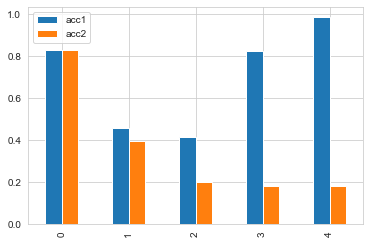

In [29]:
pd.DataFrame({'acc1': acc_by_output, 'acc2': acc_up_to_out}).plot.bar();

## Fine Tune VGG16 weights

In [30]:
vgg16.trainable = True
# Fine-tune from this layer onwards
start_fine_tuning_at = 1

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:start_fine_tuning_at]:
    layer.trainable =  False

In [31]:
model.compile(optimizer='adam',
              loss=weighted_entropy,
              metrics=[weighted_accuracy])

In [32]:
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

In [33]:
history_fine_tune = model.fit(x=X_train,
                              y=y_train,
                              validation_split=.1,
                              batch_size=32,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              callbacks=[early_stopping])

Train on 30052 samples, validate on 3340 samples
Epoch 12/62
30052/30052 [==============================] - 426s 14ms/sample - loss: 1.2553 - weighted_accuracy: 0.5814 - val_loss: 2.3113 - val_weighted_accuracy: 0.4176
Epoch 13/62
30052/30052 [==============================] - 425s 14ms/sample - loss: 0.9112 - weighted_accuracy: 0.6833 - val_loss: 1.6165 - val_weighted_accuracy: 0.6145
Epoch 14/62
30052/30052 [==============================] - 423s 14ms/sample - loss: 0.6979 - weighted_accuracy: 0.7553 - val_loss: 1.6942 - val_weighted_accuracy: 0.6376
Epoch 15/62
30052/30052 [==============================] - 424s 14ms/sample - loss: 0.5504 - weighted_accuracy: 0.8132 - val_loss: 0.6740 - val_weighted_accuracy: 0.7997
Epoch 16/62
30052/30052 [==============================] - 426s 14ms/sample - loss: 0.4287 - weighted_accuracy: 0.8573 - val_loss: 0.5488 - val_weighted_accuracy: 0.8157
Epoch 17/62
30052/30052 [==============================] - 436s 15ms/sample - loss: 0.3544 - weighted

KeyboardInterrupt: 

In [ ]:
metrics_tuned = metrics.append(pd.DataFrame(history_fine_tune.history), ignore_index=True)

In [ ]:
metrics_tuned.info()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
metrics_tuned[['weighted_accuracy', 'val_weighted_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_weighted_accuracy.max():.2%})')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
for ax in axes:
    ax.axvline(14, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
    ax.set_xlabel('Epoch')
fig.tight_layout()
fig.savefig('figures/transfer_learning_svhn');